# Optimization Package
---
### Options
- Optim.NelderMead()
- Optim.SimulatedAnnealing()
- Optim.ParticleSwarm()
- Optim.ConjugateGradient()
- Optim.GradientDescent()
- Optim.BFGS()
- Optim.LBFGS()
- Optim.NGMRES()
- Optim.OACCEL()
- Optim.NewtonTrustRegion()
- Optim.Newton()
- Optim.KrylovTrustRegion()
- Optim.ParticleSwarm()
- Optim.SAMIN()

In [1]:
using DifferentialEquations, Optim, Plots, DataFrames, LinearAlgebra, ComponentArrays, CSV, BenchmarkTools

In [2]:
# Load Data
df = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/sample_data.csv"))
data = Matrix(df[:,[:"u1", :"u2", :"u3"]])
t = Vector(df.T);

In [3]:
u0 = data[1,:];

In [4]:
# define the ODE model with in-place update
function f!(dx, x, p, t)
    dx[1] = -p.a*x[1] + p.b*x[2] + p.c*x[3]
    dx[2] = p.a*x[1] - (p.b+p.d)*x[2]
    dx[3] = p.d*x[2] - (p.c+p.e)*x[3]
end

# define the error function
function error(p,t,data)
    tspan = (t[1],t[end])
    prob = ODEProblem(f!, u0, tspan, p)
    sol = solve(prob, Tsit5())
    loss = 0
    for i in 1:size(t)[1]
        pred = sol(t[i])
        loss += sum((pred - data[i,:]).^2)
    end
    return loss
end

# define the objective function
function objective(p_free)
    p = ComponentArray(a=p_free[1], b=p_free[2], c=p_free[3], d=p_free[4], e=p_free[5])
    error(p, t, data)
end

# define the parameter values: actual optimial solution is near p = [1,4,1,2,0.1]
p0 = ComponentArray(a=1.8,b=1.3,c=1.7,d=8.1,e=0.3)

# define the bounds for the optimization variables
lb = [0.0, 0.0, 0.0, 0.0, 0.0]
ub = [Inf, Inf, Inf, Inf, Inf]

# run the optimization algorithm
result = optimize(objective, lb, ub, [p0.a, p0.b, p0.c, p0.d, p0.e], NelderMead()).minimizer
minimizer = ComponentArray(a=result[1], b=result[2], c=result[3], d=result[4], e=result[5])

# print the results
println("Initial Guess: ", p0)
println("Optimial Values: ", minimizer)

Initial Guess: (a = 1.8, b = 1.3, c = 1.7, d = 8.1, e = 0.3)
Optimial Values: (a = 0.18408681356311388, b = 0.3211378911421283, c = 0.38896248511252374, d = 0.8338390640426723, e = 0.07572549496540945)


In [5]:
tspan = (t[1],t[end])
unfit_sol = solve(ODEProblem(f!, u0, tspan, p0), Tsit5())
unfit_error = error(p0, t, data)
fit_sol = solve(ODEProblem(f!, u0, tspan, minimizer), Tsit5())
fit_error = error(minimizer, t, data)
print("Unfit Error: ", unfit_error, "\nFit Error: ", fit_error)

Unfit Error: 246.20424643453293
Fit Error: 1.5164309085616967

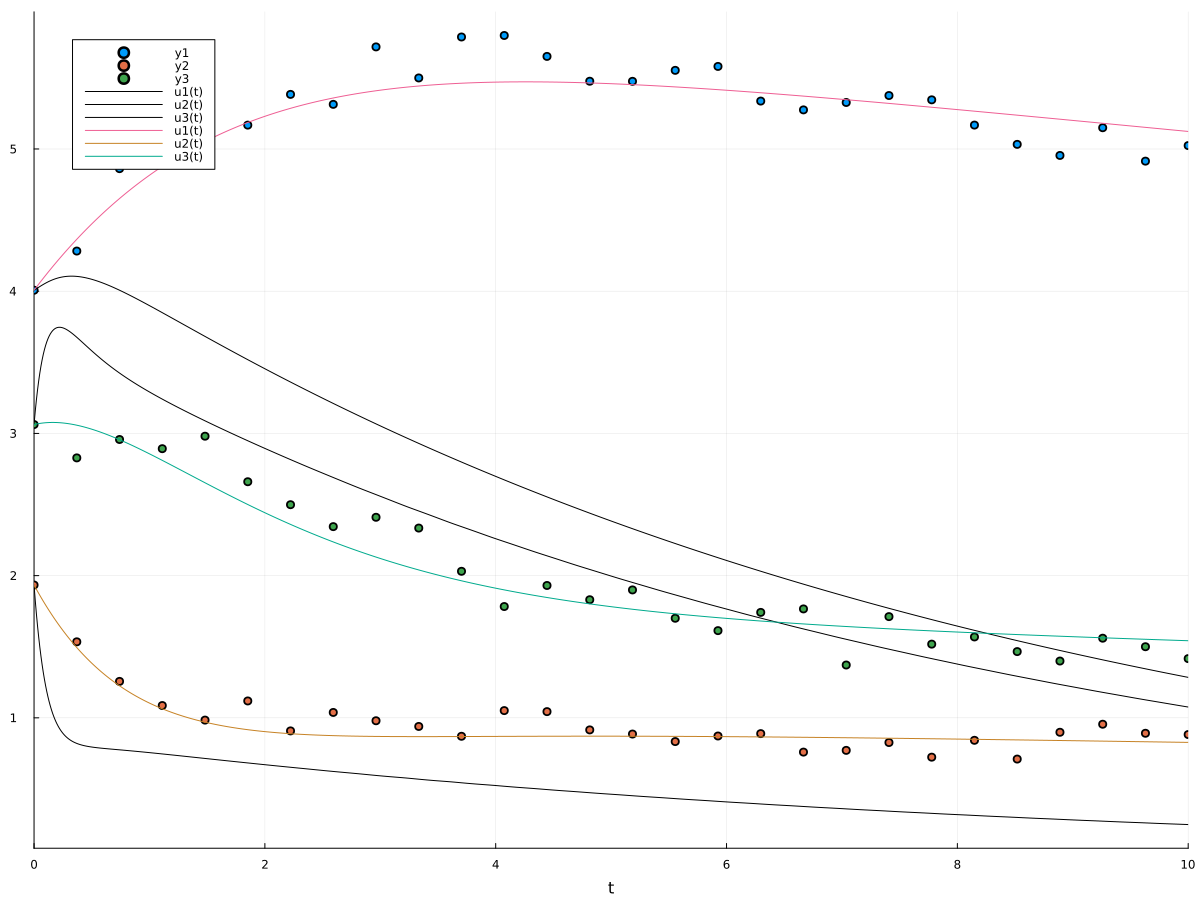

In [6]:
scatter(t, data)
plot!(unfit_sol, color="black")
plot!(fit_sol)
plot!(size=(1200,900))

## Fixed Parameter Optimization

In [7]:
# define the ODE model with in-place update
function f!(dx, x, p, t)
    dx[1] = -p.a*x[1] + p.b*x[2] + p.c*x[3]
    dx[2] = p.a*x[1] - (p.b+p.d)*x[2]
    dx[3] = p.d*x[2] - (p.c+p.e)*x[3]
end

# define the error function
function error(p,t,data)
    tspan = (t[1],t[end])
    prob = ODEProblem(f!, u0, tspan, p)
    sol = solve(prob, Tsit5())
    loss = 0
    for i in 1:size(t)[1]
        pred = sol(t[i])
        loss += sum((pred - data[i,:]).^2)
    end
    return loss
end

# define the objective function with 
function objective(p_free)
    p = ComponentArray(a=p_free[1], b=p_free[2], c=p0.c, d=p_free[3], e=p_free[4])
    error(p, t, data)
end

# define the parameter values: actual optimial solution is near p = [1,4,1,2,0.1]
p0 = ComponentArray(a=1.8,b=1.3,c=1.7,d=8.1,e=0.3)

# define the bounds for the optimization variables
lb = [0.0, 0.0, 0.0, 0.0, 0.0]
ub = [Inf, Inf, Inf, Inf, Inf]

# run the optimization algorithm
result = optimize(objective, lb, ub, [p0.a, p0.b, p0.d, p0.e], NelderMead()).minimizer

4-element Vector{Float64}:
  0.11611964864735831
 -2.6909959510414914
  3.4177417111204056
  0.07525712433877557

In [8]:
tspan = (t[1],t[end])
unfit_sol = solve(ODEProblem(f!, u0, tspan, p0), Tsit5())
unfit_error = error(p0, t, data)
fit_sol = solve(ODEProblem(f!, u0, tspan, minimizer), Tsit5())
fit_error = error(minimizer, t, data)
print("Unfit Error: ", unfit_error, "\nFit Error: ", fit_error)

Unfit Error: 246.20424643453293
Fit Error: 1.5164309085616967

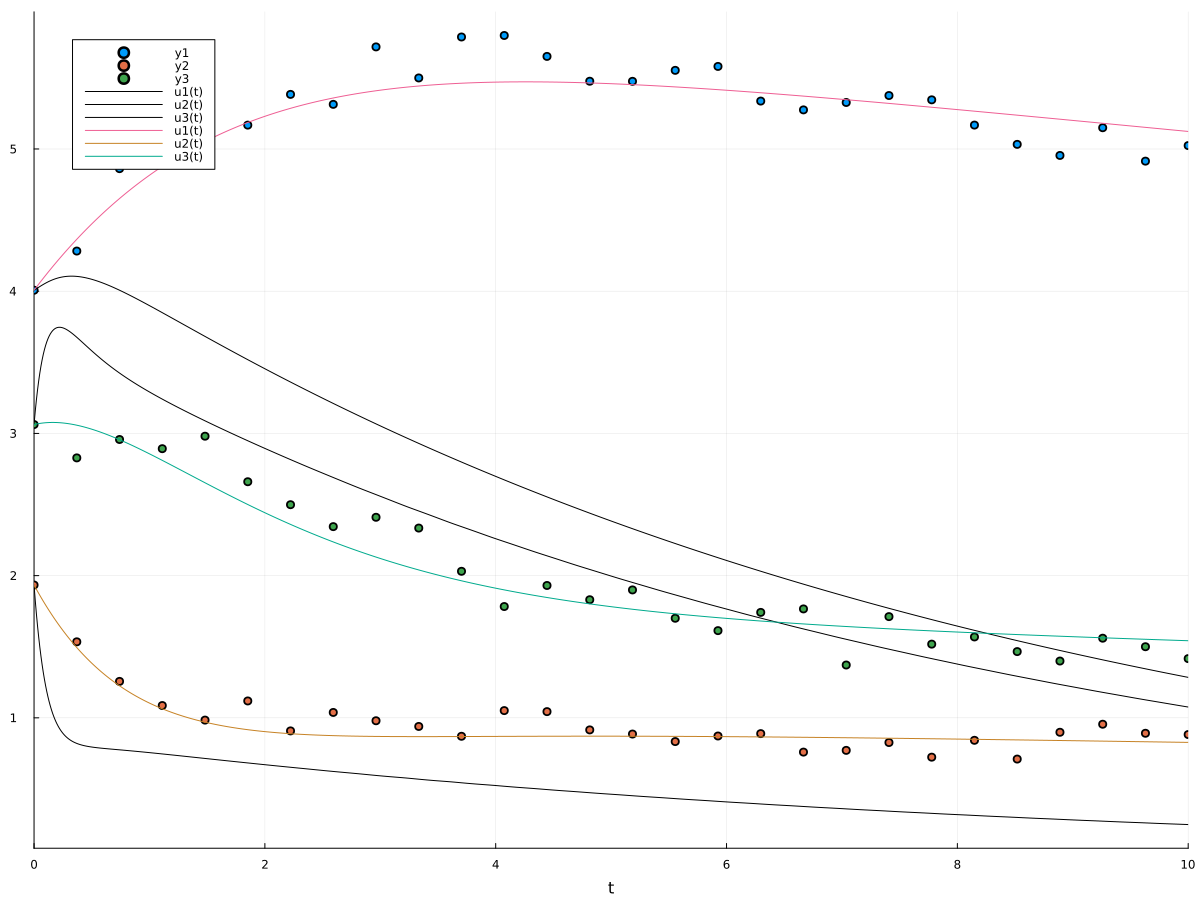

In [9]:
scatter(t, data)
plot!(unfit_sol, color="black")
plot!(fit_sol)
plot!(size=(1200,900))

### ThyrosimIM Estimation

In [10]:
# Import sample data
sample_IM = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/sample_IM.csv"));

In [11]:
function fixed_parameters()
    p = zeros(Float64, 100)
    dial=[1.0; 0.88; 1.0; 0.88]
    p[1] = 0.0027785399344 #S4
    p[2] = 8               #tau
    p[3] = 0.868           #k12
    p[4] = 0.108           #k13
    p[5] = 584             #k31free
    p[6] = 1503            #k21free
    p[7] = 0.000289        #A
    p[8] = 0.000214        #B
    p[9] = 0.000128        #C
    p[10] = -8.83*10^-6    #D
    p[11] = 0.88           #k4absorb
    p[12] = 0.0189         #k02
    p[13] = 0.012101809339 #VmaxD1fast
    p[14] = 2.85           #KmD1fast
    p[15] = 6.63*10^-4     #VmaxD1slow
    p[16] = 95             #KmD1slow
    p[17] = 0.00074619     #VmaxD2slow
    p[18] = 0.075          #KmD2slow
    p[19] = 3.3572*10^-4   #S3
    p[20] = 5.37           #k45
    p[21] = 0.0689         #k46
    p[22] = 127            #k64free
    p[23] = 2043           #k54free
    p[24] = 0.00395        #a
    p[25] = 0.00185        #b
    p[26] = 0.00061        #c
    p[27] = -0.000505      #d
    p[28] = 0.88           #k3absorb
    p[29] = 0.184972339613 #k05
    p[30] = 450            #Bzero
    p[31] = 219.7085301388 #Azero
    p[32] = 0              #Amax
    p[33] = -3.71          #phi
    p[34] = 0.53           #kdegTSH-HYPO
    p[35] = 0.226          #VmaxTSH
    p[36] = 23             #K50TSH
    p[37] = 0.058786935033 #k3
    p[38] = 0.29           #T4P-EU
    p[39] = 0.006          #T3P-EU
    p[40] = 0.037          #KdegT3B
    p[41] = 0.0034         #KLAG-HYPO
    p[42] = 5              #KLAG
    p[43] = 1.3            #k4dissolve
    p[44] = 0.12           #k4excrete
    p[45] = 1.78           #k3dissolve
    p[46] = 0.12           #k3excrete
    p[47] = 3.2            #Vp
    p[48] = 5.2            #VTSH
    p[49] = 3.001011022378 #K_circ
    p[50] = 3.094711690204 #K_SR_tsh
    p[51] = 5.674773816316 #n_hillcirc
    p[52] = 6.290803221796 #m_hillTSH
    p[53] = 8.498343729591 #K_f4 for f4
    p[54] = 14.36664496926 #l_hillf3
    p[57] = dial[1] # controls T4 secretion rate
    p[58] = dial[2] # controls T4 excretion rate
    p[59] = dial[3] # controls T3 secretion rate
    p[60] = dial[4] # controls T3 excretion rate
    p[61] = 5.003761571969437   # σT4
    p[62] = 0.11122955089297369 # σT3
    p[63] = 0.4                 # σTSH
    p[64] = 0.1                 # σFT4
    p[65] = 21.82854404275587 # maleBMI_ref
    p[66] = 22.99050845201536 # femaleBMI_ref
    p[67] = 1.0 #Vtsh_scale
    p[69] = 1.0 # PV_ratio
    p[70] = -1.0 # PV
    p[71] = 1.0 # PV_allometric_exp
    p[72] = 1.0 # fat_free
    p[73] = 0.0 # fat
    p[74] = 1.0 # slow_scale
    p[75] = 1.0 # fast_scale
    p[76] = 0.75 # male_allometric
    p[77] = 0.75 # female_allometric
    p[78] = 1.7608716659237555 # male_ref_height
    p[79] = 1.6696106891941103 # female_ref_height
    p[80] = 1.0499391485135692 # male_clearace
    p[81] = 0.0 # T4 infusion
    p[82] = 0.0 # T3 infusion

    return p
end

function ics()
    ic    = zeros(Float64, 25)
    ic[1] = 0.322114215761171 #T4dot
    ic[2] = 0.201296960359917 #T4fast
    ic[3] = 0.638967411907560 #T4slow
    ic[4] = 0.00663104034826483 #T3pdot
    ic[5] = 0.0112595761822961 #T3fast
    ic[6] = 0.0652960640300348 #T3slow
    ic[7] = 1.78829584764370 #TSHp
    ic[8] = 7.05727560072869 #T3B
    ic[9] = 7.05714474742141 #T3B_lag
    ic[10] = 0 #T4PILLdot
    ic[11] = 0 #T4GUTdot
    ic[12] = 0 #T3PILLdot
    ic[13] = 0 #T3GUTdot
    ic[14] = 3.34289716182018 #delay1
    ic[15] = 3.69277248068433 #delay2
    ic[16] = 3.87942133769244 #delay3
    ic[17] = 3.90061903207543 #delay4
    ic[18] = 3.77875734283571 #delay5
    ic[19] = 3.55364471589659 #delay6
    ic[20] = 100 # B-cells
    ic[21] = 20 # Plasma cells 
    ic[22] = 100 # CD4+ cells
    ic[23] = 5e9 # Cytokines
    ic[24] = 5 # FTS
    ic[25] = 2e9 # Antibodies

    return ic
end

ics (generic function with 1 method)

In [12]:
function initialize_free()
    p = zeros(18)
    p[1] = 3e-3 # B-cell activation rate, will probably be lower due to T3 term p[15]
    p[2] = 1e-2 # Plasma cell transformation rate
    p[3] = 8.05e-1 # CD4+ activation rate
    p[4] = 51.84e5 # Cytokine production rate
    p[5] = 1e6 # relative growth rate of FTS
    p[6] = 1e6 # combined antibody production rate
    p[7] = 2e-6 # B-cell death rate
    p[8] = 4.0e-2 # Plasma cell death rate
    p[9] = 8.91e-3 # CD4+ cell death rate
    p[10] = .189  # Cytokine degredation rate
    p[11] = 1e-2 # Functional thyroid destruction rate
    p[12] = 1.74e-3 # Blood Ab degredation rate
    p[13] = 18e5 # B-cell cytokine binding activation threshold
    p[14] = 2e6 # CD4+ T-cell cytokine binding activation threshold
    p[15] = 1e3 # NOTE: NEED TO FIT and CHANGE
    p[16] = 9.1e-4 # CD4+ T-cell stimulation rate
    # p[17] = 0.25 # Maximum thyroid growth ratio
    p[18] = 13.5 # Euthyroid FTS
    return p
end
    

initialize_free (generic function with 1 method)

In [13]:
function thyrosimIM_estimate(dq, q, p, t)
    kdelay = 5/8
    fixed_p = fixed_parameters()
    dial=[1.0; 0.88; 1.0; 0.88]

    # scaling the mass/concentration of compartments
    fixed_plasma_volume_ratio = fixed_p[69]^fixed_p[71]
    slow_volume_ratio = fixed_p[74]^fixed_p[71]
    fast_volume_ratio = fixed_p[75]^fixed_p[71]

    # scale comparment sizes
    q1 = q[1] * 1 / fixed_p[69]
    q2 = q[2] * 1 / fixed_p[75]
    q3 = q[3] * 1 / fixed_p[74]
    q4 = q[4] * 1 / fixed_p[69]
    q5 = q[5] * 1 / fixed_p[75]
    q6 = q[6] * 1 / fixed_p[74]
    q7 = q[7] * 1 / fixed_p[69]

    # Auxillary equations
    q4F = (fixed_p[24]+ fixed_p[25] * q1 + fixed_p[26] * q1^2 + fixed_p[27] * q1^3) * q4 #FT3p
    q1F = (fixed_p[7] + fixed_p[8] * q1 + fixed_p[9] * q1^2 + fixed_p[10] * q1^3) * q1  #FT4p
    SR3 = (q[24]/p[18])*(fixed_p[19] * fixed_p[59] * q[19]) # Scaled (q[24]/fixed_p[100]) Brain delay (dial 3)
    SR4 = (q[24]/p[18])*(fixed_p[1] * fixed_p[57] * q[19])  # Scaled (q[24]/fixed_p[100]) Brain delay (dial 1)
    fCIRC = q[9]^fixed_p[51] / (q[9]^fixed_p[51] + fixed_p[49]^fixed_p[51])
    SRTSH = (fixed_p[30]+fixed_p[31]*fCIRC*sin(pi/12*t-fixed_p[33]))*(fixed_p[50]^fixed_p[52]/(fixed_p[50]^fixed_p[52] + q[9]^fixed_p[52]))
    fdegTSH = fixed_p[34] + fixed_p[35] / (fixed_p[36] + q7)
    fLAG = fixed_p[41] + 2*q[8]^11 / (fixed_p[42]^11 + q[8]^11)
    f4 = fixed_p[37]*(1 + 5*(fixed_p[53]^fixed_p[54]) / (fixed_p[53]^fixed_p[54]+q[8]^fixed_p[54]))
    NL = fixed_p[13] / (fixed_p[14] + q2)

    # ODEs
    dq[1]  = fixed_p[81] + (SR4 + fixed_p[3] * q2 + fixed_p[4] * q3 - (fixed_p[5] + fixed_p[6]) * q1F) * fixed_plasma_volume_ratio + fixed_p[11] * q[11] #T4dot (need to remove u1)
    dq[2]  = (fixed_p[6] * q1F - (fixed_p[3] + fixed_p[12] + NL) * q2) * fast_volume_ratio                                    #T4fast
    dq[3]  = (fixed_p[5] * q1F -(fixed_p[4] + fixed_p[15] / (fixed_p[16] + q3) + fixed_p[17] /(fixed_p[18] + q3)) * q3) * slow_volume_ratio  #T4slow
    dq[4]  = fixed_p[82] + (SR3 + fixed_p[20] * q5 + fixed_p[21] * q6 - (fixed_p[22] + fixed_p[23]) * q4F) * fixed_plasma_volume_ratio + fixed_p[28] * q[13] #T3pdot
    dq[5]  = (fixed_p[23] * q4F + NL * q2 - (fixed_p[20] + fixed_p[29]) * q5) * fast_volume_ratio                         #T3fast
    dq[6]  = (fixed_p[22] * q4F + fixed_p[15] * q3 / (fixed_p[16] + q3) + fixed_p[17] * q3 / (fixed_p[18] + q3) -(fixed_p[21])*q6) * slow_volume_ratio #T3slow
    dq[7]  = (SRTSH - fdegTSH * q7) * fixed_plasma_volume_ratio                                           #TSHfixed_p
    dq[8]  = f4 / fixed_p[38] * q1 + fixed_p[37] / fixed_p[39] * q4 - fixed_p[40] * q[8]          #T3B
    dq[9]  = fLAG * (q[8] - q[9])                                             #T3B LAG
    dq[10] = -fixed_p[43] * q[10]                                                   #T4PILLdot
    dq[11] =  fixed_p[43] * q[10] - (fixed_p[44] * fixed_p[58]+ fixed_p[11]) * q[11]                  #T4GUTdot: note fixed_p[44] * fixed_p[58] = fixed_p[44] * dial[2] = k4excrete
    dq[12] = -fixed_p[45] * q[12]                                                   #T3PILLdot
    dq[13] =  fixed_p[45] * q[12] - (fixed_p[46] * fixed_p[60] + fixed_p[28]) * q[13]                 #T3GUTdot: note fixed_p[46] * fixed_p[60] = fixed_p[46] * dial[4] = k3excrete

    # Delay ODEs
    dq[14] = kdelay * (q7 - q[14]) 
    dq[15] = kdelay * (q[14] - q[15])                                         #delay2: TSH delay
    dq[16] = kdelay * (q[15] - q[16])                                         #delay3
    dq[17] = kdelay * (q[16] - q[17])                                         #delay4
    dq[18] = kdelay * (q[17] - q[18])                                         #delay5
    dq[19] = kdelay * (q[18] - q[19])
    
    # Immune ODEs
    dq[20] = p[1]*(q[23]/(q[23]+p[13]))*q[22]+p[15]*q4F-(p[7]+p[2])*q[20] # Bdot
    dq[21] = p[2]*q[20]-p[8]*q[21] # Pdot
    dq[22] = p[3]*q[24]+p[16]*(q[23]/(q[23]+p[14]))*q[22]-p[9]*q[22] # Tdot
    dq[23] = p[4]*q[22]-p[8]*q[23] # Cdot
    dq[24] = p[5]*((q7/q[24])*p[18])-p[11]*(q[24])*q[25] #p[9]*((q7/q[24])*p[17])-p[10]*(q[24]/p[17])*q[25] # FTSdot MODIFIED
    dq[25] = p[6]*q[21]-q[25]*(p[12]+p[11]*q[24]) # Abdot

    return dq
end

thyrosimIM_estimate (generic function with 1 method)

In [28]:
"""
Run parameter estimation on immune parameters. 
"""
function fit_params(data::DataFrame, p0::Vector)

    t = data.t
    ic = ics()    
    sol_index = [1,4,7,20,21,22,23,24,25]
    cols = names(sample_IM)[2:10]

    function error(p,t,data)
        tspan = (t[1],t[end])
        prob = ODEProblem(thyrosimIM_estimate, ic, tspan, p)
        sol = solve(prob, Rosenbrock23())

        loss = 0
        for i in 1:size(cols)[1]
            dp = 1
            for time in t
                loss += ((sol(time)[sol_index[i]]-data[!,cols[i]][dp])/mean(data[!,cols[i]]))^2
                dp += 1
            end
        end
        return loss
    end

    function objective(p_free)
        return error(p_free, t, data)
    end

    lb = zeros(size(p0)[1])
    ub = fill(Inf, size(p0)[1])

    # Adjust so fitting indicies and parameters can be specified
    result = optimize(objective, p0, NelderMead(),
     Optim.Options(time_limit = 200.0, iterations = 10000, g_tol=1e-5,
     show_trace = true, allow_f_increases=true))
end

fit_params

In [29]:
"""
Run parameter estimation on immune parameters. 
"""
function prefit_error(data::DataFrame, p0::Vector)

    t = data.t
    ic = ics()    
    sol_index = [1,4,7,20,21,22,23,24,25]
    cols = names(sample_IM)[2:10]

    function error(p,t,data)
        tspan = (t[1],t[end])
        prob = ODEProblem(thyrosimIM_estimate, ic, tspan, p)
        sol = solve(prob, Rosenbrock23())

        loss = 0
        for i in 1:size(cols)[1]
            dp = 1
            for time in t
                loss += ((sol(time)[sol_index[i]]-data[!,cols[i]][dp])/mean(data[!,cols[i]]))^2
                dp += 1
            end
            print("Column: ", cols[i], "\n")
            print("Current Error: ", loss, "\n\n")
        end
        return loss
    end

    function objective(p_free)
        return error(p_free, t, data)
    end

    objective(p0)

end

prefit_error(sample_IM, p0)

Column: T4
Current Error: 0.6003075832470719

Column: T3
Current Error: 1.2124771013741247

Column: TSH
Current Error: 2.076782875552838

Column: Bcells
Current Error: 2.3593683767240696

Column: Plasma
Current Error: 2.6563708837085764

Column: CD4
Current Error: 3.0319375287027124

Column: Cytokine
Current Error: 1714.8766908885311

Column: FTS


Current Error: 1715.2038153879325

Column: Ab
Current Error: 1715.6385547886382



1715.6385547886382

In [30]:
p0 = initialize_free();

In [31]:
optimal_params = fit_params(sample_IM, p0)

Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.748029e+02     4.372951e+11
 * time: 0.0


     1     2.748029e+02     1.592525e+03
 * time: 0.07500004768371582


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596


     2     2.308962e+02     1.278074e+03
 * time: 0.12599992752075195


     3     2.308962e+02     1.124593e+03
 * time: 0.21899986267089844


     4     2.308962e+02     1.039070e+03
 * time: 0.28099989891052246


     5     5.558845e+01     1.010365e+03
 * time: 0.312999963760376


     6     5.558845e+01     9.707097e+02
 * time: 0.3450000286102295


     7     5.558845e+01     8.797657e+02
 * time: 0.42299985885620117


     8     5.558845e+01     8.070104e+02
 * time: 0.5019998550415039


     9     5.558845e+01     7.390958e+02
 * time: 0.5729999542236328


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596


    10     5.558845e+01     7.092647e+02
 * time: 0.6459999084472656


    11     5.558845e+01     6.978346e+02
 * time: 0.6789999008178711


    12     5.558845e+01     6.780543e+02
 * time: 0.7159998416900635


┌ Warning: dt(1.1368683772161603e-13) <= dtmin(1.1368683772161603e-13) at t=5.848114078823249e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589


    13     5.558845e+01     6.563237e+02
 * time: 0.8179998397827148


    14     5.558845e+01     6.567541e+02
 * time: 0.8499999046325684
    15     5.558845e+01     6.466649e+02
 * time: 0.8819999694824219


    16     5.558845e+01     6.251969e+02
 * time: 0.9459998607635498


    17     5.558845e+01     5.909338e+02
 * time: 0.9779999256134033


    18     5.558845e+01     5.414590e+02
 * time: 1.0130000114440918


    19     5.558845e+01     4.749559e+02
 * time: 1.055999994277954


    20     5.558845e+01     3.900984e+02
 * time: 1.125999927520752


    21     5.558845e+01     3.472343e+02
 * time: 1.178999900817871


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596


    22     5.558845e+01     2.910274e+02
 * time: 1.251999855041504


    23     5.558845e+01     2.332715e+02
 * time: 1.307999849319458


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596


    24     5.558845e+01     1.557848e+02
 * time: 1.3589999675750732


    25     5.558845e+01     1.223856e+02
 * time: 1.4189999103546143


┌ Warning: dt(1.1368683772161603e-13) <= dtmin(1.1368683772161603e-13) at t=7.69018980962706e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589


    26     5.558845e+01     1.018510e+02
 * time: 1.4530000686645508
    27     5.558845e+01     9.150667e+01
 * time: 1.4860000610351562


    28     5.558845e+01     8.049083e+01
 * time: 1.560999870300293


    29     5.558845e+01     7.170485e+01
 * time: 1.8309998512268066


    30     5.558845e+01     6.267546e+01
 * time: 1.88100004196167
    31     5.558845e+01     5.265076e+01
 * time: 1.9099998474121094


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596


    32     5.558845e+01     5.166401e+01
 * time: 1.9700000286102295
    33     5.558845e+01     4.608144e+01


 * time: 2.0339999198913574


    34     5.558845e+01     4.538053e+01
 * time: 2.0969998836517334


    35     5.558845e+01     4.339609e+01
 * time: 2.1599998474121094


    36     5.558845e+01     4.116248e+01
 * time: 2.2360000610351562


    37     5.558845e+01     3.859354e+01
 * time: 2.2860000133514404


    38     5.558845e+01     3.660874e+01
 * time: 2.3369998931884766
    39     5.558845e+01     3.421480e+01
 * time: 2.368000030517578


    40     5.558845e+01     3.276928e+01
 * time: 2.425999879837036


    41     5.558845e+01     3.147450e+01
 * time: 2.555000066757202


    42     5.558845e+01     3.055345e+01
 * time: 2.6489999294281006


    43     5.558845e+01     2.982396e+01
 * time: 2.7300000190734863


    44     5.558845e+01     2.931078e+01
 * time: 2.7760000228881836


    45     5.558845e+01     2.819734e+01
 * time: 2.809999942779541


    46     5.558845e+01     2.822910e+01
 * time: 2.86899995803833


    47     5.558845e+01     2.716785e+01
 * time: 2.9559998512268066
    48     5.558845e+01     2.673993e+01
 * time: 2.990000009536743


    49     5.558845e+01     2.578671e+01
 * time: 3.056999921798706


    50     5.558845e+01     2.484061e+01
 * time: 3.0920000076293945


    51     5.558845e+01     2.369186e+01
 * time: 3.1649999618530273


    52     5.558845e+01     2.243313e+01
 * time: 3.2330000400543213


    53     5.558845e+01     2.183165e+01
 * time: 3.2820000648498535


    54     5.558845e+01     2.100094e+01
 * time: 3.36299991607666


    55     5.558845e+01     2.023145e+01
 * time: 3.427999973297119


    56     5.558845e+01     2.002425e+01
 * time: 3.4630000591278076


    57     5.558845e+01     1.917623e+01
 * time: 3.5349998474121094


    58     5.558845e+01     1.877537e+01
 * time: 3.5839998722076416


    59     5.558845e+01     2.035944e+01
 * time: 3.812000036239624


    60     5.408867e+01     1.942061e+01
 * time: 3.86299991607666


    61     5.408867e+01     1.865067e+01


 * time: 3.9059998989105225


    62     5.408867e+01     1.773530e+01
 * time: 4.006999969482422


    63     5.408867e+01     1.704433e+01
 * time: 4.07699990272522


    64     5.408867e+01     1.631846e+01
 * time: 4.144999980926514


    65     5.408867e+01     1.608889e+01
 * time: 4.187000036239624


    66     5.408867e+01     1.562237e+01
 * time: 4.233999967575073


    67     5.408867e+01     1.483352e+01
 * time: 4.316999912261963


    68     5.408867e+01     1.393055e+01
 * time: 4.421000003814697


    69     5.408867e+01     1.347574e+01
 * time: 4.474999904632568


    70     5.408867e+01     1.290485e+01
 * time: 4.549999952316284


    71     5.408867e+01     1.244730e+01
 * time: 4.609999895095825


    72     5.408867e+01     1.214841e+01
 * time: 4.6499998569488525


    73     5.408867e+01     1.173431e+01
 * time: 4.730000019073486


    74     5.408867e+01     1.140372e+01
 * time: 4.763999938964844


    75     5.408867e+01     1.167615e+01
 * time: 4.8399999141693115


    76     5.408867e+01     1.163691e+01
 * time: 4.921999931335449


    77     5.408867e+01     1.139815e+01
 * time: 4.958999872207642


    78     5.408867e+01     1.097747e+01
 * time: 5.0299999713897705


    79     5.408867e+01     1.069686e+01
 * time: 5.1549999713897705
    80     5.408867e+01     1.042252e+01
 * time: 5.192999839782715


    81     5.408867e+01     1.007315e+01
 * time: 5.284999847412109


    82     5.408867e+01     1.016207e+01
 * time: 5.333999872207642


    83     5.408867e+01     9.783332e+00
 * time: 5.372999906539917


    84     5.408867e+01     9.326522e+00
 * time: 5.447999954223633


    85     5.408867e+01     8.840204e+00
 * time: 5.517999887466431


    86     5.408867e+01     9.726352e+00
 * time: 5.5920000076293945


    87     4.995417e+01     9.425097e+00
 * time: 5.773000001907349
    88     4.995417e+01     9.411795e+00
 * time: 5.796999931335449


    89     4.995417e+01     9.806200e+00
 * time: 5.86899995803833


    90     4.995417e+01     9.550538e+00
 * time: 5.9029998779296875


    91     4.995417e+01     9.856829e+00
 * time: 5.960999965667725


    92     4.995417e+01     9.648782e+00
 * time: 6.009000062942505


    93     4.995417e+01     9.375990e+00
 * time: 6.08899998664856


    94     4.995417e+01     9.479029e+00
 * time: 6.134000062942505


    95     4.995417e+01     9.070884e+00
 * time: 6.2159998416900635


    96     4.995417e+01     8.664277e+00
 * time: 6.302000045776367


    97     4.995417e+01     8.383617e+00
 * time: 6.338000059127808


    98     4.995417e+01     8.278240e+00
 * time: 6.375999927520752


    99     4.995417e+01     7.819810e+00
 * time: 6.440999984741211


   100     4.995417e+01     7.334178e+00
 * time: 6.5


   101     4.995417e+01     6.791393e+00
 * time: 6.572000026702881


   102     4.995417e+01     6.198251e+00
 * time: 6.641000032424927


   103     4.995417e+01     5.892737e+00
 * time: 6.733000040054321


   104     4.995417e+01     5.414476e+00
 * time: 6.816999912261963


   105     4.995417e+01     7.324274e+00
 * time: 6.884000062942505


   106     3.680038e+01     7.267568e+00
 * time: 6.91700005531311


   107     3.680038e+01     7.368355e+00
 * time: 7.013000011444092


   108     3.680038e+01     7.160517e+00
 * time: 7.044999837875366


   109     3.680038e+01     7.163972e+00
 * time: 7.079999923706055


   110     3.680038e+01     7.138036e+00
 * time: 7.1579999923706055


   111     3.680038e+01     6.831954e+00
 * time: 7.226000070571899


   112     3.680038e+01     7.102591e+00
 * time: 7.259000062942505


   113     3.680038e+01     7.067068e+00
 * time: 7.303999900817871


   114     3.680038e+01     7.210967e+00
 * time: 7.338000059127808


   115     3.680038e+01     6.772051e+00
 * time: 7.371999979019165


   116     3.680038e+01     6.288866e+00
 * time: 7.437999963760376


   117     3.680038e+01     5.725784e+00
 * time: 7.677999973297119


   118     3.680038e+01     5.997926e+00
 * time: 7.74399995803833


   119     3.560235e+01     5.810207e+00
 * time: 7.812999963760376


   120     3.560235e+01     5.623660e+00
 * time: 7.858000040054321
   121     3.560235e+01     8.093189e+00
 * time: 7.925999879837036


   122     2.043464e+01     7.948758e+00
 * time: 7.993000030517578


   123     2.043464e+01     7.796258e+00
 * time: 8.056999921798706


   124     2.043464e+01     7.562125e+00
 * time: 8.121999979019165
   125     2.043464e+01     7.308930e+00
 * time: 8.187999963760376


   126     2.043464e+01     7.314800e+00
 * time: 8.238999843597412


   127     2.043464e+01     7.014740e+00
 * time: 8.322999954223633


   128     2.043464e+01     6.695999e+00
 * time: 8.391000032424927


   129     2.043464e+01     6.331731e+00
 * time: 8.437999963760376


   130     2.043464e+01     6.450850e+00
 * time: 8.473999977111816


   131     2.043464e+01     6.241951e+00
 * time: 8.50600004196167


   132     2.043464e+01     6.117412e+00
 * time: 8.57800006866455


   133     2.043464e+01     5.971361e+00
 * time: 8.619999885559082


   134     2.043464e+01     6.238811e+00
 * time: 8.700999975204468


   135     2.043464e+01     6.021699e+00
 * time: 8.734999895095825


   136     2.043464e+01     6.411860e+00
 * time: 8.76799988746643


   137     2.043464e+01     6.199564e+00
 * time: 8.832000017166138


   138     2.043464e+01     6.159707e+00
 * time: 8.869999885559082


   139     2.043464e+01     7.074827e+00
 * time: 8.953999996185303


   140     1.841194e+01     6.844443e+00
 * time: 9.03600001335144


   141     1.841194e+01     6.620544e+00
 * time: 9.105999946594238


   142     1.841194e+01     6.408649e+00
 * time: 9.139999866485596


   143     1.841194e+01     6.214341e+00
 * time: 9.174999952316284


   144     1.841194e+01     5.943609e+00
 * time: 9.398000001907349


   145     1.841194e+01     5.679800e+00
 * time: 9.471999883651733


   146     1.841194e+01     5.375987e+00
 * time: 9.523000001907349


   147     1.841194e+01     5.180393e+00
 * time: 9.589999914169312


   148     1.841194e+01     5.159156e+00
 * time: 9.622999906539917


   149     1.841194e+01     5.021828e+00
 * time: 9.687999963760376


   150     1.841194e+01     4.856267e+00
 * time: 9.754999876022339


   151     1.841194e+01     4.918138e+00
 * time: 9.819000005722046


   152     1.841194e+01     4.766562e+00
 * time: 9.8510000705719


   153     1.841194e+01     4.744793e+00
 * time: 9.889999866485596


   154     1.841194e+01     4.579074e+00
 * time: 9.924000024795532


   155     1.841194e+01     4.469769e+00
 * time: 9.98799991607666


   156     1.841194e+01     4.329555e+00
 * time: 10.062000036239624


   157     1.841194e+01     4.327206e+00
 * time: 10.111000061035156
   158     1.841194e+01     4.178958e+00
 * time: 10.175999879837036


   159     1.841194e+01     3.998016e+00
 * time: 10.282999992370605


   160     1.841194e+01     3.962744e+00
 * time: 10.32699990272522


   161     1.841194e+01     3.698967e+00
 * time: 10.391999959945679


   162     1.841194e+01     3.434740e+00
 * time: 10.425999879837036


   163     1.841194e+01     3.256246e+00
 * time: 10.483999967575073


   164     1.841194e+01     3.020859e+00
 * time: 10.560999870300293


   165     1.841194e+01     2.893038e+00
 * time: 10.611999988555908


   166     1.841194e+01     2.655826e+00
 * time: 10.65999984741211
   167     1.841194e+01     2.394776e+00
 * time: 10.724999904632568


   168     1.841194e+01     2.321883e+00
 * time: 10.756999969482422
   169     1.841194e+01     2.452912e+00
 * time: 10.822999954223633


   170     1.713622e+01     2.374764e+00
 * time: 10.888999938964844


   171     1.713622e+01     2.282275e+00
 * time: 10.924999952316284


   172     1.713622e+01     2.214115e+00


 * time: 11.148000001907349
   173     1.713622e+01     2.265915e+00
 * time: 11.17199993133545


   174     1.713622e+01     2.234483e+00
 * time: 11.210000038146973


   175     1.713622e+01     2.374956e+00
 * time: 11.276000022888184


   176     1.628101e+01     2.354800e+00
 * time: 11.307999849319458


   177     1.628101e+01     2.296742e+00
 * time: 11.346999883651733


   178     1.628101e+01     2.332898e+00
 * time: 11.432999849319458


   179     1.628101e+01     2.339745e+00
 * time: 11.490999937057495


   180     1.628101e+01     2.274242e+00
 * time: 11.526000022888184


   181     1.628101e+01     2.386081e+00
 * time: 11.622999906539917


   182     1.506832e+01     2.368029e+00
 * time: 11.678999900817871


   183     1.506832e+01     2.238456e+00
 * time: 11.727999925613403


   184     1.506832e+01     2.090272e+00
 * time: 11.807999849319458


   185     1.506832e+01     1.996330e+00
 * time: 11.840999841690063


   186     1.506832e+01     1.969467e+00
 * time: 11.876999855041504


   187     1.506832e+01     1.917692e+00
 * time: 11.94599986076355


   188     1.506832e+01     1.951120e+00
 * time: 12.01199984550476


   189     1.460398e+01     1.874761e+00
 * time: 12.075000047683716


   190     1.460398e+01     1.719677e+00
 * time: 12.10699987411499


   191     1.460398e+01     1.556097e+00
 * time: 12.139999866485596


   192     1.460398e+01     1.444220e+00
 * time: 12.20799994468689


   193     1.453526e+01     1.308811e+00
 * time: 12.273000001907349


   194     1.453526e+01     1.249195e+00
 * time: 12.33899998664856


   195     1.419160e+01     1.120808e+00
 * time: 12.45300006866455


   196     1.419160e+01     1.180248e+00
 * time: 12.543999910354614


   197     1.303536e+01     1.215102e+00
 * time: 12.638000011444092


   198     1.303536e+01     1.137460e+00
 * time: 12.675999879837036


   199     1.303536e+01     1.236021e+00
 * time: 12.764999866485596


   200     1.265928e+01     1.231385e+00
 * time: 12.997999906539917


   201     1.265928e+01     1.239850e+00
 * time: 13.055000066757202


   202     1.265928e+01     1.457646e+00
 * time: 13.124000072479248


   203     1.094678e+01     1.453236e+00
 * time: 13.198999881744385


   204     1.094678e+01     1.443716e+00
 * time: 13.289999961853027


   205     1.094678e+01     1.382389e+00
 * time: 13.323999881744385


   206     1.094678e+01     1.383368e+00
 * time: 13.438999891281128


   207     1.094678e+01     1.328077e+00
 * time: 13.536999940872192


   208     1.094678e+01     1.366139e+00
 * time: 13.634000062942505


   209     1.094678e+01     1.303453e+00
 * time: 13.72000002861023


   210     1.094678e+01     1.229112e+00
 * time: 13.777999877929688


   211     1.094678e+01     1.135819e+00
 * time: 13.874000072479248


   212     1.094678e+01     1.062762e+00
 * time: 13.924000024795532


   213     1.094678e+01     1.072205e+00
 * time: 14.003999948501587


   214     1.082037e+01     1.019286e+00
 * time: 14.085000038146973


   215     1.082037e+01     9.371336e-01
 * time: 14.182999849319458


   216     1.082037e+01     8.636719e-01
 * time: 14.270999908447266


   217     1.082037e+01     7.794330e-01
 * time: 14.361999988555908


   218     1.082037e+01     7.275421e-01
 * time: 14.398000001907349


   219     1.082037e+01     7.251983e-01
 * time: 14.484999895095825


   220     1.077126e+01     7.243494e-01
 * time: 14.555000066757202


   221     1.073766e+01     7.439654e-01
 * time: 14.641999959945679


   222     1.031210e+01     7.618272e-01
 * time: 14.73799991607666


   223     1.031210e+01     7.581473e-01
 * time: 14.971999883651733


   224     1.031210e+01     7.570239e-01
 * time: 15.027999877929688


   225     1.018056e+01     7.265564e-01
 * time: 15.111000061035156


   226     1.018056e+01     6.912037e-01
 * time: 15.20799994468689


   227     1.018056e+01     6.817821e-01
 * time: 15.342000007629395


   228     9.729661e+00     6.152849e-01
 * time: 15.376999855041504


   229     9.729661e+00     5.617568e-01
 * time: 15.419999837875366


   230     9.729661e+00     5.944518e-01
 * time: 15.516999959945679


   231     9.381570e+00     5.959845e-01
 * time: 15.625


   232     9.381570e+00     5.800756e-01
 * time: 15.700000047683716


   233     9.381570e+00     5.363345e-01
 * time: 15.759999990463257


   234     9.381570e+00     5.233680e-01
 * time: 15.832000017166138


   235     9.381570e+00     5.749355e-01
 * time: 15.899999856948853


   236     8.925828e+00     5.453164e-01
 * time: 15.950999975204468


   237     8.925828e+00     5.899629e-01
 * time: 16.042999982833862


   238     8.925828e+00     6.273292e-01
 * time: 16.124000072479248


   239     8.890997e+00     6.233822e-01
 * time: 16.18499994277954


   240     8.890997e+00     6.118398e-01
 * time: 16.264999866485596


   241     8.890997e+00     5.915847e-01
 * time: 16.335999965667725


   242     8.890997e+00     5.951898e-01
 * time: 16.425999879837036


   243     8.803211e+00     5.721150e-01
 * time: 16.51799988746643


   244     8.803211e+00     5.614961e-01
 * time: 16.578999996185303


   245     8.803211e+00     6.471036e-01
 * time: 16.662999868392944


   246     7.886547e+00     6.133816e-01
 * time: 16.700000047683716


   247     7.886547e+00     6.093597e-01
 * time: 16.738999843597412


   248     7.886547e+00     5.735828e-01
 * time: 16.822999954223633


   249     7.886547e+00     5.307208e-01
 * time: 17.066999912261963


   250     7.886547e+00     4.748258e-01
 * time: 17.14299988746643


   251     7.886547e+00     4.570712e-01
 * time: 17.180000066757202


   252     7.886547e+00     4.316266e-01
 * time: 17.217999935150146


   253     7.886547e+00     4.152570e-01
 * time: 17.25600004196167


   254     7.886547e+00     4.215702e-01
 * time: 17.348000049591064


   255     7.886547e+00     3.949982e-01
 * time: 17.384999990463257


   256     7.886547e+00     3.946391e-01
 * time: 17.463000059127808


   257     7.886547e+00     3.955276e-01
 * time: 17.54099988937378


   258     7.886547e+00     3.877341e-01
 * time: 17.596999883651733


   259     7.886547e+00     3.924947e-01
 * time: 17.674999952316284


   260     7.789152e+00     3.841305e-01
 * time: 17.71499991416931


   261     7.789152e+00     3.901633e-01
 * time: 17.796000003814697


   262     7.789152e+00     3.721240e-01
 * time: 17.832000017166138


   263     7.789152e+00     3.719727e-01
 * time: 17.92799997329712


   264     7.789152e+00     3.615296e-01
 * time: 17.96399998664856


   265     7.789152e+00     3.599660e-01
 * time: 18.050999879837036


   266     7.662421e+00     3.336938e-01
 * time: 18.111999988555908


   267     7.662421e+00     3.130260e-01
 * time: 18.20799994468689


   268     7.662421e+00     2.986854e-01
 * time: 18.306999921798706
   269     7.662421e+00     2.815367e-01
 * time: 18.340999841690063


   270     7.662421e+00     2.600016e-01
 * time: 18.430000066757202


   271     7.622082e+00     2.377089e-01
 * time: 18.46499991416931


   272     7.622082e+00     2.587577e-01
 * time: 18.603999853134155


   273     7.321027e+00     2.763141e-01
 * time: 18.70199990272522


   274     7.281993e+00     2.618626e-01
 * time: 18.76199984550476


   275     7.281993e+00     2.599256e-01
 * time: 18.859999895095825


   276     7.281993e+00     2.601358e-01
 * time: 19.098999977111816
   277     7.281993e+00     2.627510e-01
 * time: 19.164999961853027


   278     7.281993e+00     2.604688e-01
 * time: 19.250999927520752


   279     7.281993e+00     2.667816e-01
 * time: 19.3439998626709


   280     7.096940e+00     2.441719e-01
 * time: 19.382999897003174


   281     7.096940e+00     2.524171e-01
 * time: 19.437999963760376


   282     7.096940e+00     2.392152e-01
 * time: 19.490000009536743


   283     7.096940e+00     2.352655e-01
 * time: 19.56500005722046


   284     7.096940e+00     2.306155e-01
 * time: 19.605000019073486


   285     7.096940e+00     2.404340e-01
 * time: 19.680999994277954


   286     6.998993e+00     2.307305e-01
 * time: 19.740999937057495


   287     6.998993e+00     2.318356e-01
 * time: 19.83899998664856


   288     6.995824e+00     2.326529e-01
 * time: 19.932999849319458


   289     6.995542e+00     2.278271e-01
 * time: 20.000999927520752


   290     6.995542e+00     2.197573e-01
 * time: 20.078999996185303


   291     6.974638e+00     2.065780e-01
 * time: 20.134000062942505


   292     6.974638e+00     1.912973e-01
 * time: 20.230000019073486


   293     6.974638e+00     1.764023e-01
 * time: 20.325999975204468


   294     6.951823e+00     1.556112e-01
 * time: 20.425999879837036


   295     6.937761e+00     1.446357e-01
 * time: 20.55299997329712


   296     6.936822e+00     1.536340e-01
 * time: 20.62999987602234


   297     6.784217e+00     1.476922e-01
 * time: 20.66700005531311


   298     6.784217e+00     1.438828e-01
 * time: 20.753999948501587


   299     6.784217e+00     1.406799e-01
 * time: 20.816999912261963


   300     6.784217e+00     1.385655e-01
 * time: 20.917999982833862


   301     6.733496e+00     1.291953e-01
 * time: 21.152999877929688


   302     6.733496e+00     1.396675e-01
 * time: 21.20799994468689


   303     6.600855e+00     1.314635e-01
 * time: 21.259999990463257


   304     6.600855e+00     1.412019e-01
 * time: 21.353999853134155


   305     6.600855e+00     1.476135e-01
 * time: 21.42799997329712


   306     6.590297e+00     1.523121e-01
 * time: 21.500999927520752


   307     6.590297e+00     1.466470e-01
 * time: 21.569999933242798


   308     6.590297e+00     1.526113e-01
 * time: 21.641000032424927


   309     6.562312e+00     1.459947e-01
 * time: 21.694000005722046


   310     6.562312e+00     1.505265e-01
 * time: 21.77900004386902


   311     6.522966e+00     1.453544e-01
 * time: 21.875999927520752


   312     6.522966e+00     1.370731e-01
 * time: 21.93400001525879


   313     6.522966e+00     1.442252e-01
 * time: 22.02900004386902


   314     6.421411e+00     1.387116e-01
 * time: 22.111000061035156


   315     6.421411e+00     1.284379e-01
 * time: 22.18499994277954


   316     6.421411e+00     1.185548e-01
 * time: 22.286999940872192


   317     6.421411e+00     1.535299e-01
 * time: 22.39800000190735


   318     6.160388e+00     1.485923e-01
 * time: 22.473999977111816


   319     6.160388e+00     1.418277e-01
 * time: 22.527999877929688


   320     6.160388e+00     1.402407e-01
 * time: 22.592999935150146


   321     6.160388e+00     1.335497e-01
 * time: 22.626999855041504


   322     6.160388e+00     1.247500e-01
 * time: 22.674999952316284


   323     6.160388e+00     1.295455e-01
 * time: 22.73799991607666


   324     6.160388e+00     1.255444e-01
 * time: 22.812000036239624


   325     6.160388e+00     1.231468e-01
 * time: 22.918999910354614


   326     6.160388e+00     1.219090e-01
 * time: 23.01900005340576


   327     6.160388e+00     1.227427e-01
 * time: 23.269999980926514


   328     6.160388e+00     1.190424e-01
 * time: 23.296000003814697


   329     6.160388e+00     1.200198e-01
 * time: 23.342000007629395


   330     6.160388e+00     1.159656e-01
 * time: 23.394999980926514


   331     6.160388e+00     1.101802e-01
 * time: 23.44099998474121


   332     6.160388e+00     1.090952e-01
 * time: 23.532999992370605


   333     6.160388e+00     1.080457e-01
 * time: 23.569999933242798


   334     6.160388e+00     1.231458e-01
 * time: 23.639999866485596


   335     6.076429e+00     1.427238e-01
 * time: 23.75


   336     5.999011e+00     1.371054e-01
 * time: 23.835999965667725


   337     5.999011e+00     1.292977e-01
 * time: 23.872999906539917


   338     5.999011e+00     1.226617e-01
 * time: 23.961999893188477


   339     5.999011e+00     1.181097e-01
 * time: 24.0479998588562


   340     5.999011e+00     1.143259e-01
 * time: 24.102999925613403
   341     5.999011e+00     1.107915e-01
 * time: 24.138999938964844


   342     5.999011e+00     1.037198e-01
 * time: 24.19700002670288


   343     5.999011e+00     1.013643e-01
 * time: 24.283999919891357


   344     5.999011e+00     1.161832e-01
 * time: 24.394999980926514


   345     5.927957e+00     1.145935e-01
 * time: 24.460000038146973


   346     5.927957e+00     1.164292e-01
 * time: 24.51699995994568


   347     5.927957e+00     1.356366e-01
 * time: 24.59500002861023


   348     5.811903e+00     1.307627e-01
 * time: 24.687000036239624


   349     5.811903e+00     1.278854e-01
 * time: 24.740999937057495


   350     5.811903e+00     1.304371e-01
 * time: 24.780999898910522


   351     5.811903e+00     1.247664e-01
 * time: 24.86299991607666


   352     5.811903e+00     1.202119e-01
 * time: 24.967000007629395


   353     5.811903e+00     1.147881e-01
 * time: 25.003000020980835


   354     5.811903e+00     1.109701e-01
 * time: 25.04099988937378


   355     5.811903e+00     1.043433e-01
 * time: 25.078999996185303


   356     5.811903e+00     1.006291e-01
 * time: 25.167999982833862


   357     5.811903e+00     9.698684e-02
 * time: 25.42799997329712


   358     5.811903e+00     9.205170e-02
 * time: 25.480000019073486


   359     5.811903e+00     9.044365e-02
 * time: 25.514999866485596


   360     5.811903e+00     9.581902e-02
 * time: 25.598999977111816


   361     5.796773e+00     8.913684e-02
 * time: 25.662999868392944


   362     5.796773e+00     8.116925e-02
 * time: 25.76199984550476


   363     5.796773e+00     7.562148e-02
 * time: 25.85800004005432


   364     5.796773e+00     7.814435e-02
 * time: 25.91599988937378


   365     5.796773e+00     7.739228e-02
 * time: 26.01199984550476


   366     5.796773e+00     7.535463e-02
 * time: 26.082000017166138


   367     5.796773e+00     7.582496e-02
 * time: 26.134000062942505


   368     5.796773e+00     1.062833e-01
 * time: 26.23799991607666


   369     5.557352e+00     1.029913e-01
 * time: 26.276000022888184


   370     5.557352e+00     1.045815e-01
 * time: 26.312999963760376


   371     5.557352e+00     1.012951e-01
 * time: 26.38599991798401


   372     5.557352e+00     1.146513e-01
 * time: 26.442999839782715


   373     5.557352e+00     1.100189e-01
 * time: 26.486999988555908


   374     5.557352e+00     1.336272e-01
 * time: 26.613999843597412


   375     5.462929e+00     1.306892e-01
 * time: 26.700999975204468


   376     5.462929e+00     1.275099e-01
 * time: 26.77900004386902


   377     5.462929e+00     1.239472e-01
 * time: 26.840999841690063


   378     5.462929e+00     1.252419e-01
 * time: 26.884999990463257


   379     5.462929e+00     1.205952e-01
 * time: 27.001999855041504


   380     5.462929e+00     1.156002e-01
 * time: 27.098000049591064


   381     5.462929e+00     1.132812e-01
 * time: 27.13599991798401


   382     5.462929e+00     1.091450e-01
 * time: 27.213000059127808


   383     5.462929e+00     1.093710e-01
 * time: 27.264999866485596


   384     5.462929e+00     1.182513e-01
 * time: 27.418999910354614


   385     5.447841e+00     1.162139e-01
 * time: 27.669999837875366


   386     5.447841e+00     1.141168e-01
 * time: 27.692999839782715
   387     5.447841e+00     1.152983e-01
 * time: 27.723000049591064


   388     5.447841e+00     1.108342e-01
 * time: 27.763000011444092


   389     5.447841e+00     1.054625e-01
 * time: 27.805000066757202


   390     5.447841e+00     9.975655e-02
 * time: 27.848000049591064


   391     5.447841e+00     9.960573e-02
 * time: 27.91100001335144


   392     5.447841e+00     9.555580e-02
 * time: 27.971999883651733


   393     5.447841e+00     9.121340e-02
 * time: 28.036999940872192


   394     5.447841e+00     9.206607e-02
 * time: 28.075999975204468


   395     5.447841e+00     8.641859e-02
 * time: 28.167999982833862


   396     5.447841e+00     8.016101e-02
 * time: 28.221999883651733


   397     5.447841e+00     1.001880e-01
 * time: 28.30299997329712


   398     5.271006e+00     9.419390e-02
 * time: 28.36299991607666


   399     5.271006e+00     8.993416e-02
 * time: 28.40400004386902


   400     5.271006e+00     8.546305e-02
 * time: 28.48199987411499


   401     5.271006e+00     8.254976e-02
 * time: 28.586999893188477


   402     5.271006e+00     8.020720e-02
 * time: 28.657000064849854


   403     5.271006e+00     8.819168e-02
 * time: 28.692999839782715


   404     5.271006e+00     8.604567e-02
 * time: 28.746000051498413


   405     5.271006e+00     8.229971e-02
 * time: 28.842999935150146


   406     5.271006e+00     7.908471e-02
 * time: 28.901000022888184


   407     5.271006e+00     8.305208e-02
 * time: 28.960000038146973


   408     5.271006e+00     8.805640e-02
 * time: 29.019999980926514


   409     5.271006e+00     8.462295e-02
 * time: 29.08299994468689


   410     5.271006e+00     9.359644e-02
 * time: 29.15999984741211


   411     5.226617e+00     9.264495e-02
 * time: 29.194999933242798


   412     5.226617e+00     8.832161e-02
 * time: 29.234999895095825


   413     5.226617e+00     8.384198e-02
 * time: 29.31599998474121


   414     5.226617e+00     8.035132e-02
 * time: 29.378999948501587


   415     5.226617e+00     7.833892e-02
 * time: 29.425999879837036


   416     5.226617e+00     7.513069e-02
 * time: 29.47099995613098


   417     5.226617e+00     7.199650e-02
 * time: 29.55399990081787


   418     5.226617e+00     7.898202e-02
 * time: 29.794999837875366


   419     5.203517e+00     7.511847e-02
 * time: 29.817999839782715


   420     5.203517e+00     7.144715e-02
 * time: 29.866999864578247


   421     5.203517e+00     7.740239e-02
 * time: 29.97000002861023


   422     5.180174e+00     7.753650e-02
 * time: 30.030999898910522


   423     5.180174e+00     8.274299e-02
 * time: 30.10199999809265


   424     5.146350e+00     8.369296e-02
 * time: 30.16700005531311


   425     5.146350e+00     7.945920e-02
 * time: 30.26799988746643


   426     5.146350e+00     7.736127e-02
 * time: 30.358999967575073


   427     5.146350e+00     9.026499e-02
 * time: 30.438999891281128


   428     5.053144e+00     8.691216e-02
 * time: 30.4760000705719


   429     5.053144e+00     8.311238e-02
 * time: 30.550999879837036


   430     5.053144e+00     7.942209e-02
 * time: 30.58999991416931


   431     5.053144e+00     7.692472e-02
 * time: 30.639999866485596


   432     5.053144e+00     7.356187e-02
 * time: 30.710000038146973


   433     5.053144e+00     7.201720e-02
 * time: 30.764999866485596


   434     5.053144e+00     6.819455e-02
 * time: 30.85599994659424


   435     5.053144e+00     7.042140e-02
 * time: 30.89199995994568


   436     5.053144e+00     8.146713e-02
 * time: 30.967000007629395


   437     5.008412e+00     7.704383e-02
 * time: 31.055000066757202


   438     5.008412e+00     7.296223e-02
 * time: 31.092000007629395


   439     5.008412e+00     7.045731e-02
 * time: 31.145999908447266


   440     5.008412e+00     7.199706e-02
 * time: 31.19599986076355


   441     5.008412e+00     8.071257e-02
 * time: 31.294999837875366


   442     4.979252e+00     7.956762e-02
 * time: 31.328999996185303


   443     4.979252e+00     7.815381e-02
 * time: 31.384000062942505


   444     4.979252e+00     8.861053e-02
 * time: 31.480000019073486


   445     4.937088e+00     8.836246e-02
 * time: 31.513000011444092


   446     4.937088e+00     8.596690e-02
 * time: 31.546000003814697


   447     4.937088e+00     8.289074e-02
 * time: 31.61899995803833


   448     4.937088e+00     7.949405e-02
 * time: 31.8510000705719
   449     4.937088e+00     7.557290e-02
 * time: 31.871999979019165


   450     4.937088e+00     7.136092e-02
 * time: 31.95199990272522


   451     4.937088e+00     7.177686e-02
 * time: 32.013999938964844


   452     4.937088e+00     6.926571e-02
 * time: 32.04900002479553


   453     4.937088e+00     6.687481e-02
 * time: 32.09099984169006


   454     4.937088e+00     6.347505e-02
 * time: 32.16499996185303


   455     4.937088e+00     7.032907e-02
 * time: 32.23399996757507


   456     4.922233e+00     6.741170e-02
 * time: 32.30999994277954


   457     4.922233e+00     6.669657e-02
 * time: 32.36899995803833


   458     4.922233e+00     7.103032e-02
 * time: 32.40599989891052


   459     4.922233e+00     7.025692e-02
 * time: 32.44199991226196


   460     4.922233e+00     6.861433e-02
 * time: 32.49900007247925


   461     4.922233e+00     6.594141e-02
 * time: 32.556999921798706


   462     4.922233e+00     6.501751e-02
 * time: 32.59599995613098


   463     4.922233e+00     7.125953e-02
 * time: 32.669999837875366


   464     4.894621e+00     6.907173e-02
 * time: 32.74900007247925


   465     4.894621e+00     6.658938e-02
 * time: 32.85699987411499


   466     4.894621e+00     6.668387e-02
 * time: 32.89299988746643


   467     4.894621e+00     6.370849e-02
 * time: 32.96000003814697


   468     4.894621e+00     6.157083e-02
 * time: 32.996999979019165


   469     4.894621e+00     6.086550e-02
 * time: 33.0460000038147


   470     4.894621e+00     6.734607e-02
 * time: 33.126999855041504


   471     4.828097e+00     6.324780e-02
 * time: 33.20199990272522


   472     4.828097e+00     5.991069e-02
 * time: 33.25499987602234


   473     4.828097e+00     5.612941e-02
 * time: 33.317999839782715


   474     4.828097e+00     5.176715e-02
 * time: 33.41199994087219


   475     4.828097e+00     6.818300e-02
 * time: 33.486000061035156


   476     4.737854e+00     6.937635e-02
 * time: 33.5220000743866


   477     4.737854e+00     6.649935e-02
 * time: 33.5939998626709


   478     4.737854e+00     6.397738e-02
 * time: 33.668999910354614


   479     4.737854e+00     6.478850e-02
 * time: 33.85699987411499


   480     4.737854e+00     6.314691e-02
 * time: 33.87899994850159


   481     4.737854e+00     6.071169e-02
 * time: 33.907999992370605


   482     4.737854e+00     5.987738e-02
 * time: 33.942999839782715


   483     4.737854e+00     5.691654e-02
 * time: 33.980000019073486


   484     4.737854e+00     5.772417e-02
 * time: 34.01900005340576


   485     4.737854e+00     5.692834e-02
 * time: 34.085999965667725


   486     4.737854e+00     5.600068e-02
 * time: 34.12100005149841


   487     4.737854e+00     5.378474e-02
 * time: 34.15700006484985


   488     4.737854e+00     5.526173e-02
 * time: 34.19599986076355


   489     4.737854e+00     5.394165e-02
 * time: 34.251999855041504


   490     4.737854e+00     5.813204e-02
 * time: 34.32099986076355


   491     4.724902e+00     5.554695e-02
 * time: 34.37599992752075


   492     4.724902e+00     5.285113e-02
 * time: 34.42400002479553


   493     4.724902e+00     6.230350e-02
 * time: 34.50499987602234


   494     4.658226e+00     5.890094e-02
 * time: 34.57200002670288


   495     4.658226e+00     5.922106e-02
 * time: 34.638999938964844


   496     4.658226e+00     5.644258e-02
 * time: 34.67799997329712


   497     4.658226e+00     5.431047e-02
 * time: 34.71399998664856


   498     4.658226e+00     5.086343e-02
 * time: 34.75699996948242


   499     4.658226e+00     5.208563e-02
 * time: 34.793999910354614


   500     4.658226e+00     5.445132e-02
 * time: 34.83500003814697


   501     4.658226e+00     5.234451e-02
 * time: 34.875


   502     4.658226e+00     6.269317e-02
 * time: 34.9449999332428


   503     4.588938e+00     6.025207e-02
 * time: 35.0


   504     4.588938e+00     5.761512e-02
 * time: 35.09299993515015


In [100]:
function plot_estIM(data)

    tvals = data.t./24

    p1 = scatter(tvals, data.T4, ylabel="T4 (mcg/L)")    
    p2 = scatter(tvals, data.T3, ylabel="T3 (mcg/L)")    
    p3 = scatter(tvals, data.TSH, ylabel="TSH (mU/L)")
    p4 = scatter(tvals, data.Bcells, ylabel="Bcell (cell/mL)")
    p5 = scatter(tvals, data.Plasma, ylabel="Plasma Cell (cell/mL)")
    p6 = scatter(tvals, data.CD4, ylabel="CD4+ Cell (cell/mL)")
    p7 = scatter(tvals, data.Cytokine, ylabel="Cytokines (nM)")
    p8 = scatter(tvals, data.FTS, ylabel="Functional Thyroid Size (mL)")
    p9 = scatter(tvals, data.Ab, ylabel="TPOAb (pM)")

    plot!(size=(900,900))
    plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout=(3, 3))

end

plot_estIM (generic function with 1 method)

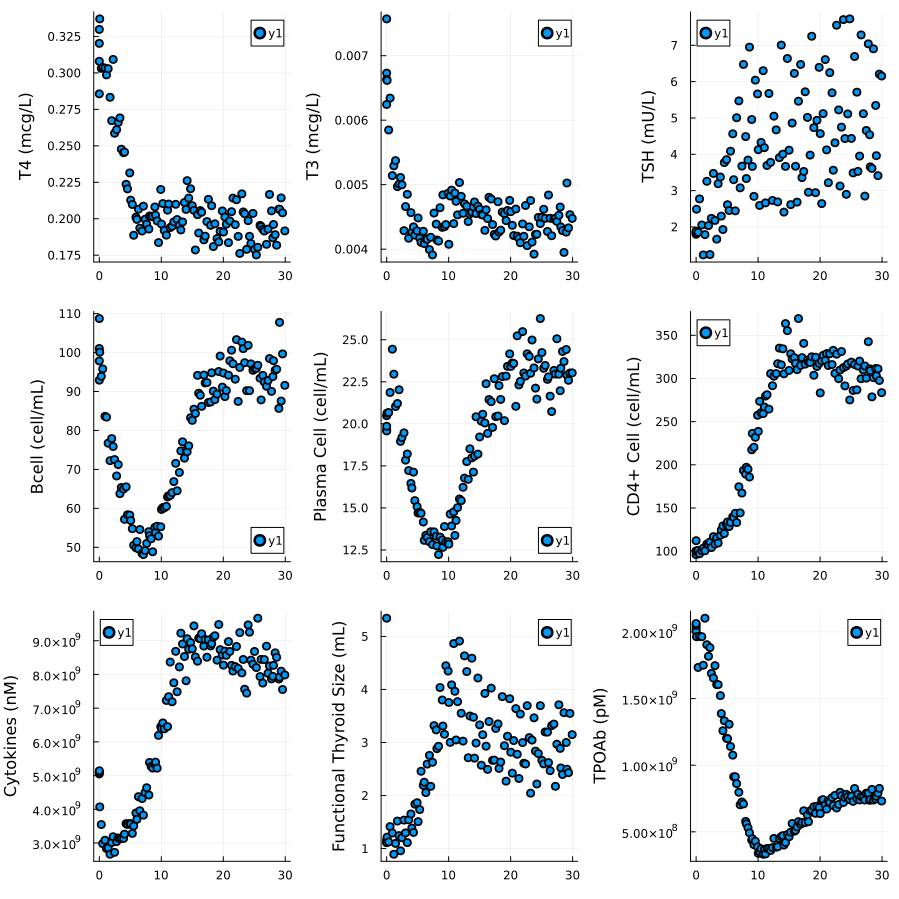

In [101]:
plot_estIM(sample_IM)

In [204]:
p0 = initialize_free()
tspan=(0.0,720.0)
ic = ics()    
prob = ODEProblem(thyrosimIM_estimate, ic, tspan, optimal_params.minimizer)
sol = solve(prob, TRBDF2())

retcode: MaxIters
Interpolation: 3rd order Hermite
t: 231382-element Vector{Float64}:
 0.0
 1.7941938165343259e-12
 1.9736131981877582e-11
 1.9915551363531015e-10
 1.9933493301696358e-9
 1.9935287495512893e-8
 3.114899884885243e-8
 3.1587034448592256e-8
 3.596739044599051e-8
 4.144283544273833e-8
 ⋮
 0.0007966447158018849
 0.0007966498022192036
 0.0007966501995955566
 0.0007966541733590869
 0.0007966591405634997
 0.0007966595286263444
 0.0007966634092547919
 0.0007966682600403513
 0.0007966712917813259
u: 231382-element Vector{Vector{Float64}}:
 [0.322114215761171, 0.201296960359917, 0.63896741190756, 0.00663104034826483, 0.0112595761822961, 0.0652960640300348, 1.7882958476437, 7.05727560072869, 7.05714474742141, 0.0  …  3.87942133769244, 3.90061903207543, 3.77875734283571, 3.55364471589659, 100.0, 20.0, 100.0, 5.0e9, 5.0, 2.0e9]
 [0.3221142157611644, 0.20129696035991748, 0.6389674119075602, 0.006631040348263248, 0.011259576182296935, 0.06529606403003488, 1.7882958476452915, 7.05727560